# Tutorial (Text Data Processing)

(Last updated: Jan 29, 2025)[^credit]

[^credit]: Credit: this teaching material is created by [Robert van Straten](https://github.com/robertvanstraten) and revised by [Alejandro Monroy](https://github.com/amonroym99) under the supervision of [Yen-Chia Hsu](https://github.com/yenchiah).

This tutorial will familiarize you with the data science pipeline of processing text data. We will go through the various steps involved in the Natural Language Processing (NLP) pipeline for topic modelling and topic classification, including tokenization, lemmatization, and obtaining word embeddings. We will also build a neural network using PyTorch for multi-class topic classification using the dataset.

The AG's News Topic Classification Dataset contains news articles from four different categories, making it a nice source of text data for NLP tasks. We will guide you through the process of understanding the dataset, implementing various NLP techniques, and building a model for classification.

You can use the following links to jump to the tasks and assignments:
*   [Task 3: Preprocess Text Data](#t3)
    *   [Tokenization](#t3-1)
    *   [Part-of-speech tagging](#t3-2)
    *   [Stemming / Lemmatization](#t3-3)
    *   [Stopword Removal](#t3-4)
    *   [Assignment for Task 3.1: Tokenization and Lemmatization](#a3-1)
    *   [Assignment for Task 3.2: Word Counts](#a3-2)
    *   [Assignment for Task 3.3: Stop Words Removal](#a3-3)
    *   [Another Option: spaCy](#spacy)
*   [Task 4: Unsupervised Learning - Topic Modelling](#t4)
    *   [Assignment for Task 4](#a4)
*   [Task 5: Supervised Learning - Topic Classification](#t5)
    *   [Compute Word Embeddings](#t5-1)
    *   [Build the Classifier](#t5-2)
    *   [Optional Assignment for Task 5](#a5)

## Scenario

The [AG's News Topic Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) is a collection of over 1 million news articles from more than 2000 news sources. The dataset was created by selecting the 4 largest classes from the original corpus, resulting in 120,000 training samples and 7,600 testing samples. The dataset is provided by the academic community for research purposes in data mining, information retrieval, and other non-commercial activities. We will use it to demonstrate various NLP techniques on real data, and in the end, make 2 models with this data. The files train.csv and test.csv contain all the training and testing samples as comma-separated values with 3 columns: class index, title, and description. Download train.csv and test.csv for the following tasks. 

## Import Packages

:::{important}
To make this notebook work, you need to install the packages by following the instructions in the [preparation](./preparation-text-data.md) step. You can also copy this notebook (as well as the dataset) to Google Colab and run the notebook on it.
:::

We put all the packages that are needed for this tutorial below:

In [1]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import spacy

import torch
import torch.nn as nn
import torch.optim as optim

from gensim.models import Word2Vec

from nltk.corpus import (
    stopwords,
    wordnet
)
from nltk.stem import (
    SnowballStemmer,
    WordNetLemmatizer
)
from nltk.tokenize import word_tokenize

from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    adjusted_mutual_info_score,
    adjusted_rand_score,
    confusion_matrix
)

from tqdm.notebook import tqdm

from wordcloud import WordCloud

# Import the answers for the tasks
from util.answer import (
    answer_tokenize_and_lemmatize,
    answer_get_word_counts,
    answer_remove_stopwords,
    answer_get_index_of_top_n_items
)

# Import the utility functions that are provided
from util.util import (
    check_answer_df,
    check_answer_np,
    wordnet_pos,
    reformat_data,
    visualize_word_counts,
    add_spacy_doc,
    add_spacy_tokens,
    add_padded_tensors
)

# Add tqdm functions to pandas.
tqdm.pandas()

<a name="answer"></a>

## Task Answers

Click on one of the following links to check answers for the assignments in this tutorial. **Do not check the answers before practicing the tasks.**
- [Click this for task answers if you open this notebook on your local machine](util/answer.py)
- {any}`Click this for task answers if you view this notebook on a web browser <./answer>`

<a name="util"></a>

## Utility File

Click on one of the following links to check the provided functions in the utility file for this tutorial.
- [Click this for utility functions if you open this notebook on your local machine](util/util.py)
- {any}`Click this for utility functions if you view this notebook on a web browser <./util>`

<a name="t3"></a>

## Task 3: Preprocess Text Data

In this task, we will preprocess the text data from the AG News Dataset. First, we need to load the files.

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

For performance reasons, we will only use a small subset of this dataset.

In [3]:
df_train = df_train.groupby("Class Index").head(1000)
df_test = df_test.groupby("Class Index").head(100)

In [4]:
display(df_train, df_test)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
4865,2,IOA sets up committee to probe dope scandal,"Athens, Aug 20. (PTI):In a belated damage-cont..."
4866,2,FACTBOX-Jonathan Woodgate factbox,"MADRID, Aug 20 (Reuters) - Factbox on England ..."
4867,2,British canoe pair lose out,ATHENS (Reuters) - Slovakian twins Peter and P...
4895,2,U.S. Softball Team Posts Shutout No. 7 (AP),AP - Cat Osterman struck out 10 in six innings...


,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
473,3,New Overtime Rules Take Effect,New Bush administration rules that scale back ...
479,3,"Dollar Holds Gains, Fed Comments Help",TOKYO (Reuters) - The dollar held on to the p...
481,3,Dark arts of spin evident in phoney war for Abbey,THE phoney war over the fate of Abbey grinds o...
482,3,Controversial US Overtime Rules Take Effect,New overtime rules have taken effect in the Un...


As you can see, all the classes are distributed evenly in the train and test data.

In [5]:
display(df_train["Class Index"].value_counts(), df_test["Class Index"].value_counts())

Class Index
3    1000
4    1000
2    1000
1    1000
Name: count, dtype: int64

Class Index
3    100
4    100
2    100
1    100
Name: count, dtype: int64

To make the data more understandable, we will make the classes more understandable by adding a `class` column from the original `Class Index` column, containing the category of the news article. To process both the title and news text together, we will combine the `Title` and `Description` columns into one `text` column. We will deal with just the train data until the point where we need the test data again. We provide the `reformat_data` function in the [utility file](#util) for this.

In [6]:
df_train_reformat = reformat_data(df_train)
display(df_train_reformat)

,class_idx,class,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Business,"Oil prices soar to all-time record, posing new..."
...,...,...,...
4865,2,Sports,IOA sets up committee to probe dope scandal At...
4866,2,Sports,"FACTBOX-Jonathan Woodgate factbox MADRID, Aug ..."
4867,2,Sports,British canoe pair lose out ATHENS (Reuters) -...
4895,2,Sports,U.S. Softball Team Posts Shutout No. 7 (AP) AP...


<a name="t3-1"></a>

### Tokenization 

Tokenization is the process of breaking down a text into individual tokens, which are usually words but can also be phrases or sentences. It helps language models to understand and analyze text data by breaking it down into smaller, more manageable pieces. While it may seem like a trivial task, tokenization can be applied in multiple ways and thus be a complex and challenging task influencing NLP applications.

For example, in languages like English, it is generally straightforward to identify words by using spaces as delimiters. However, there are exceptions, such as contractions like "can't" and hyphenated words like "self-driving". And in Dutch, where multiple nouns can be combined into one bigger noun without any delimiter this can be hard. How would you tokenize "hippopotomonstrosesquippedaliofobie"? In other languages, such as Chinese and Japanese, there are no spaces between words, so identifying word boundaries is much more difficult. 

To illustrate the use of tokenization, let's consider the following example, which tokenizes a sample text using the `word_tokenize` function from the NLTK package. That function uses a pre-trained tokenization model for English.

In [7]:
# Sample text.
text = "The quick brown fox jumped over the lazy dog. The cats couldn't wait to sleep all day."

# Tokenize the text.
tokens = word_tokenize(text)

# Print the text and the tokens.
print("Original text:", text)
print("Tokenized text:", tokens)

Original text: The quick brown fox jumped over the lazy dog. The cats couldn't wait to sleep all day.
Tokenized text: ['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', '.', 'The', 'cats', 'could', "n't", 'wait', 'to', 'sleep', 'all', 'day', '.']


<a name="t3-2"></a>

### Part-of-speech tagging

Part-of-speech (POS) tagging is the process of assigning each word in a text corpus with a specific part-of-speech tag based on its context and definition. The tags typically include nouns, verbs, adjectives, adverbs, pronouns, prepositions, conjunctions, interjections, and more. POS tagging can help other NLP tasks disambiguate a token somewhat due to the added context.

In [8]:
pos_tags = nltk.pos_tag(tokens)
print(pos_tags)

[('The', 'DT'), ('quick', 'JJ'), ('brown', 'NN'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.'), ('The', 'DT'), ('cats', 'NNS'), ('could', 'MD'), ("n't", 'RB'), ('wait', 'VB'), ('to', 'TO'), ('sleep', 'VB'), ('all', 'DT'), ('day', 'NN'), ('.', '.')]


<a name="t3-3"></a>

### Stemming / Lemmatization

Stemming and lemmatization are two common techniques used in NLP to preprocess and normalize text data. Both techniques involve transforming words into their root form, but they differ in their approach and the level of normalization they provide.

Stemming is a technique that involves reducing words to their base or stem form by removing any affixes or suffixes. For example, the stem of the word "lazily" would be "lazi". Stemming is a simple and fast technique that can be useful. However, it can also produce inaccurate or incorrect results since it does not consider the context or part of speech of the word.

Lemmatization, on the other hand, is a more sophisticated technique that involves identifying the base or dictionary form of a word, also known as the lemma. Unlike stemming, lemmatization can consider the part of speech (POS) of the word, which can make it more accurate and reliable. With lemmatization, the lemma of the word "lazily" would be "lazy". Lemmatization can be slower and more complex than stemming but provides a higher level of normalization.

Also, lemmatization requires POS tagging. Since the POS tagging logic in the `nltk` package is different from the `wordnet` package, we provide a function `wordnet_pos` in the [utility file](#util) for converting the POS tags. The input of the `wordnet_pos` function is a `nltk` POS tag, and the output of the function is a `wordnet` POS tag.

In [9]:
# Initialize the stemmer and lemmatizer.
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

# Perform stemming and lemmatization seperately on the tokens.
stemmed_tokens = [stemmer.stem(token) for token in tokens]
lemmatized_tokens = [lemmatizer.lemmatize(token, wordnet_pos(tag))
                     for token, tag in nltk.pos_tag(tokens)]

# Print the results.
print("Stemmed text:", stemmed_tokens)
print("Lemmatized text:", lemmatized_tokens)

Stemmed text: ['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog', '.', 'the', 'cat', 'could', "n't", 'wait', 'to', 'sleep', 'all', 'day', '.']
Lemmatized text: ['The', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazy', 'dog', '.', 'The', 'cat', 'could', "n't", 'wait', 'to', 'sleep', 'all', 'day', '.']


<a name="t3-4"></a>

### Stopword Removal

Stopword removal is a common technique used in NLP to preprocess and clean text data by removing words that are considered to be of little or no value in terms of conveying meaning or information. These words are called "stopwords" and they include common words such as "the", "a", "an", "and", "or", "but", and so on.

The purpose of stopword removal in NLP is to improve the accuracy and efficiency of text analysis and processing by reducing the noise and complexity of the data. Stopwords are often used to form grammatical structures in a sentence, but they do not carry much meaning or relevance to the main topic or theme of the text. So by removing these words, we can reduce the dimensionality of the text data, improve the performance of machine learning models, and speed up the processing of text data. NLTK has a predefined list of stopwords for English.

In [10]:
# English stopwords in NLTK.
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<a name="a3-1"></a>

### Assignment for Task 3.1: Tokenization and Lemmatization

The first step is to tokenize and lemmatize the sentences. **Your task (which is your assignment) is to write functions to do the following:**
- Since we want to use our text to make a model later on, we need to preprocess it. Add a `tokens` column to the `df_train` dataframe with the text tokenized, then lemmatize those tokens. You must use the POS tags when lemmatizing.
    - Hint: Use the `pandas.Series.apply` function with the imported `nltk.tokenize.word_tokenize` function. Recall that you can use the `pd.Series.apply?` syntax in a code cell for more information.
    - Hint: use the `nltk.stem.WordNetLemmatizer.lemmatize` function to lemmatize a token. Use the `wordnet_pos` function to obtain the POS tag for the lemmatizer. 
- Tokenizing and lemmatizing the entire dataset can take a while too. Use `tqdm` and the `pandas.Series.progress_apply` to show progress bars for the operations.

In [11]:
def tokenize_and_lemmatize(df):
    """
    Tokenize and lemmatize the text in the dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the "text" column.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the added "tokens" column.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

Our goal is to have a dataframe that looks like the following. **For simplicity, we only show the top 5 most frequent words.** Your data frame should have more rows.

In [12]:
# This part of code will take some time to run.
answer_df_with_tokens = answer_tokenize_and_lemmatize(df_train_reformat)
answer_df_with_tokens.groupby("class").head(n=5)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

,class_idx,class,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Into, the, Blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, and, Economy, Cloud, Stocks, ', Outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, from, Main, Southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, to, all-time, record, ,, po..."
78,4,Sci/Tech,"'Madden,' 'ESPN' Football Score in Different W...","['Madden, ,, ', 'ESPN, ', Football, Score, in,..."
79,4,Sci/Tech,Group to Propose New High-Speed Wireless Forma...,"[Group, to, Propose, New, High-Speed, Wireless..."
80,4,Sci/Tech,AOL to Sell Cheap PCs to Minorities and Senior...,"[AOL, to, Sell, Cheap, PCs, to, Minorities, an..."
81,4,Sci/Tech,Companies Approve New High-Capacity Disc Forma...,"[Companies, Approve, New, High-Capacity, Disc,..."
82,4,Sci/Tech,Missing June Deals Slow to Return for Software...,"[Missing, June, Deals, Slow, to, Return, for, ..."


The code below tests if the output of your function matches the expected output.

In [13]:
df_with_tokens = tokenize_and_lemmatize(df_train_reformat)
check_answer_df(df_with_tokens, answer_df_with_tokens)

Test case 1 failed.

Your output is:
None

Expected output is:
      class_idx     class                                               text  \
0             3  Business  Wall St. Bears Claw Back Into the Black (Reute...   
1             3  Business  Carlyle Looks Toward Commercial Aerospace (Reu...   
2             3  Business  Oil and Economy Cloud Stocks' Outlook (Reuters...   
3             3  Business  Iraq Halts Oil Exports from Main Southern Pipe...   
4             3  Business  Oil prices soar to all-time record, posing new...   
...         ...       ...                                                ...   
4865          2    Sports  IOA sets up committee to probe dope scandal At...   
4866          2    Sports  FACTBOX-Jonathan Woodgate factbox MADRID, Aug ...   
4867          2    Sports  British canoe pair lose out ATHENS (Reuters) -...   
4895          2    Sports  U.S. Softball Team Posts Shutout No. 7 (AP) AP...   
4896          2    Sports  Paul Hamm's example PAUL HAMM'

<a name="a3-2"></a>

### Assignment for Task 3.2: Word Counts

To see what the most used words per class are, create a new, seperate dataframe with token counts.
- Hint: use the `pandas.Series.apply` and `str.isalpha()` functions to filter out non-alphabetical tokens.
- Hint: use the `pandas.DataFrame.explode` to create one row per class and token.
- Hint: use `pandas.DataFrame.groupby` with `.size()` afterwards or `pandas.DataFrame.pivot_table` with size as the `aggfunc` to obtain the occurences per class.
- Hint: use the `pandas.Series.reset_index` function to obtain a dataframe with [class, tokens, count] as the columns.
- Hint: use the `pandas.DataFrame.sort_values` function for sorting a dataframe.

In [14]:
def get_word_counts(df, token_col="tokens"):
    """
    Generate dataframes with the word counts for each class in the data.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing at least the "class" and "tokens" columns.
    token_col : str
        Name of the column that stores the tokens.

    Returns
    -------
    pandas.DataFrame
        There should be three columns in this dataframe.
        The "class" column shows the document class.
        The "tokens" column means tokens in the document class.
        The "count" column means the number of appearances of each token in the class.
        The dataframe should be sorted by the "class" and "count" columns.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

Our goal is to have a dictionary of dataframes (one per class) that look like the following. **For simplicity, we only show the top 5 most frequent words.** Your data frame should have more rows.

In [15]:
answer_word_counts = answer_get_word_counts(answer_df_with_tokens, token_col="tokens")
answer_word_counts.groupby("class").head(n=5)

,class,tokens,count
3541,Business,the,1460
0,Business,a,1217
3587,Business,to,923
1743,Business,in,776
2424,Business,on,687
8929,Sci/Tech,the,1660
3961,Sci/Tech,a,1121
8997,Sci/Tech,to,1074
7319,Sci/Tech,of,939
4423,Sci/Tech,be,744


The code below tests if the output of your function matches the expected output.

In [16]:
word_counts = get_word_counts(df_with_tokens, token_col="tokens")
check_answer_df(answer_word_counts, word_counts)

Test case 1 failed.

Your output is:
          class      tokens  count
3541   Business         the   1460
0      Business           a   1217
3587   Business          to    923
1743   Business          in    776
2424   Business          on    687
...         ...         ...    ...
19259     World      zalmay      1
19261     World     zeitoun      1
19262     World        zesn      1
19263     World         zim      1
19265     World  zimbabwean      1

[19268 rows x 3 columns]

Expected output is:
None


We provide the `visualize_word_counts` function in the [utility file](#util) to visualize the word counts that you just computed using the [wordcloud](https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py) package.

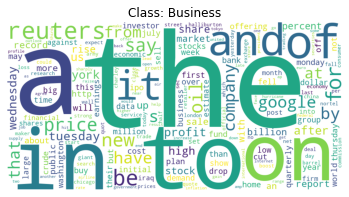

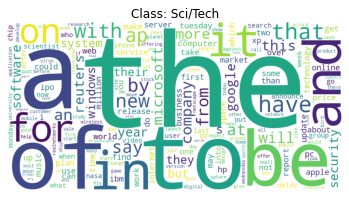

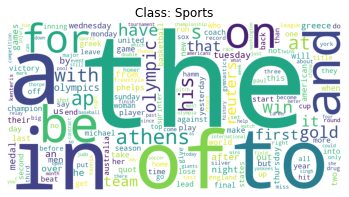

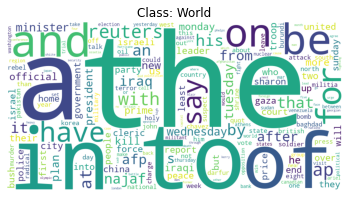

In [17]:
visualize_word_counts(answer_word_counts)

<a name="a3-3"></a>

### Assignment for Task 3.3: Stop Words Removal

The stop words make it difficult for us to identify representative words for each class. Let's display the word counts using the data without stop words. But we need to remove the stop words first. **Your task (which is your assignment) is to write functions to do the following:**
- Remove the stopwords from the tokens column in the dataframe.
  - Hint: use the `pandas.DataFrame.isin` function.
  - Hint: use the `stopwords_list` variable to help you check if a token is a stop word.

In [18]:
def remove_stopwords(df):
    """
    Remove stopwords from the tokens.

    Parameters
    ----------
    df : pandas.DataFrame
        There should be three columns in this dataframe.
        The "class" column shows the document class.
        The "tokens" column means tokens in the document class.
        The "count" column means the number of appearances of each token in the class.
        The dataframe should be sorted by the "class" and "count" columns.

    Returns
    -------
    pandas.DataFrame
        The dataframe with the stopwords rows removed.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

Our goal is to have a dictionary of dataframes (one per class) that look like the following. **For simplicity, we only show the top 5 most frequent words.** Your data frame should have more rows.

In [19]:
answer_word_counts_no_stopword = answer_remove_stopwords(answer_word_counts)
answer_word_counts_no_stopword.groupby("class").head(n=5)

,class,tokens,count
2948,Business,reuters,483
2351,Business,new,297
2698,Business,price,281
3041,Business,say,281
2419,Business,oil,278
4209,Sci/Tech,ap,236
7228,Sci/Tech,new,224
8237,Sci/Tech,say,186
4952,Sci/Tech,company,137
7031,Sci/Tech,microsoft,121


The code below tests if the output of your function matches the expected output.

In [20]:
word_counts_no_stopword = remove_stopwords(word_counts)
check_answer_df(word_counts_no_stopword, answer_word_counts_no_stopword)

Test case 1 failed.

Your output is:
None

Expected output is:
          class      tokens  count
2948   Business     reuters    483
2351   Business         new    297
2698   Business       price    281
3041   Business         say    281
2419   Business         oil    278
...         ...         ...    ...
19259     World      zalmay      1
19261     World     zeitoun      1
19262     World        zesn      1
19263     World         zim      1
19265     World  zimbabwean      1

[18787 rows x 3 columns]


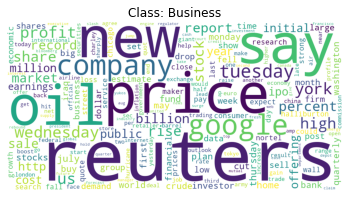

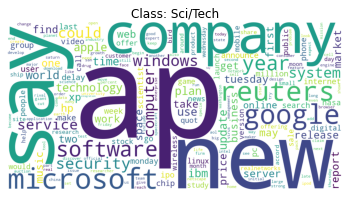

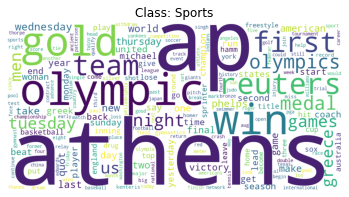

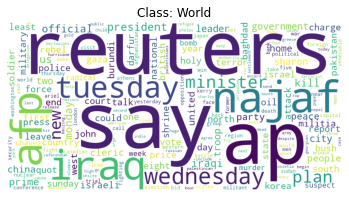

In [21]:
visualize_word_counts(answer_word_counts_no_stopword)

<a name="spacy"></a>

### Another Option: spaCy

spaCy is another library used to perform various NLP tasks like tokenization, part-of-speech tagging, named entity recognition, dependency parsing, and much more. It provides pre-trained models for different languages and domains, which can be used as-is but also can be fine-tuned on a specific task or domain.

In an object-oriented way, spaCy can be thought of as a collection of classes and objects that work together to perform NLP tasks. Some of the important functions and classes in spaCy include:

- `nlp`: The core function that provides the main functionality of spaCy. It is used to process text and create a `Doc` object.
- [`Doc`](https://spacy.io/api/doc): A container for accessing linguistic annotations like tokens, part-of-speech tags, named entities, and dependency parse information. It is created by the `nlp` function and represents a processed document.
- [`Token`](https://spacy.io/api/token): An object representing a single token in a `Doc` object. It contains information like the token text, part-of-speech tag, lemma, embedding, and much more.

When a text is processed by spaCy, it is first passed to the `nlp` function, which uses the loaded model to tokenize the text and applies various linguistic annotations like part-of-speech tagging, named entity recognition, and dependency parsing in the background. The resulting annotations are stored in a `Doc` object, which can be accessed and manipulated using various methods and attributes.

In [22]:
# Load the small English model in spaCy.
# Disable Named Entity Recognition and the parser in the model pipeline since we're not using it.
# Check the following website for the spaCy NLP pipeline:
# - https://spacy.io/usage/processing-pipelines
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Process the text using spaCy.
doc = nlp(text)

# This becomes a spaCy Doc object, which prints nicely as the original string.
print(doc)

The quick brown fox jumped over the lazy dog. The cats couldn't wait to sleep all day.


The `Doc` object can be iterated over to access each `Token` object in the document. We can also directly access multiple attributes of the `Token` objects. For example, we can directly access the lemma of the token with `Token.lemma_` and check if a token is a stop word with `Token.is_stop`. To make it easy to see them, we put them in a data frame.

In [23]:
spacy_doc_attributes = [(token, token.lemma_, token.is_stop) for token in doc]
pd.DataFrame(data=spacy_doc_attributes, columns=["token", "lemma", "is_stopword"])

,token,lemma,is_stopword
0,The,the,True
1,quick,quick,False
2,brown,brown,False
3,fox,fox,False
4,jumped,jump,False
5,over,over,True
6,the,the,True
7,lazy,lazy,False
8,dog,dog,False
9,.,.,False


The above example only deals with one sentence. Now we need to deal with all the sentences in all the classes. We provide a `add_spacy_doc` function in the [utility file](#util) to add a column with a `Doc` representation of the `text` column to the dataframe. Now we can add the spaCy tokens using the above function. This step will take some time since it needs to process all the sentences. So we added a progress bar using the `tqdm` package.

In [24]:
df_with_nltk_tokens_and_spacy_doc = add_spacy_doc(answer_df_with_tokens, nlp)
display(df_with_nltk_tokens_and_spacy_doc)

  0%|          | 0/4000 [00:00<?, ?it/s]

,class_idx,class,text,tokens,doc
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Into, the, Blac...","(Wall, St., Bears, Claw, Back, Into, the, Blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace...","(Carlyle, Looks, Toward, Commercial, Aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, and, Economy, Cloud, Stocks, ', Outlook,...","(Oil, and, Economy, Cloud, Stocks, ', Outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, from, Main, Southe...","(Iraq, Halts, Oil, Exports, from, Main, Southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, to, all-time, record, ,, po...","(Oil, prices, soar, to, all, -, time, record, ..."
...,...,...,...,...,...
4865,2,Sports,IOA sets up committee to probe dope scandal At...,"[IOA, set, up, committee, to, probe, dope, sca...","(IOA, sets, up, committee, to, probe, dope, sc..."
4866,2,Sports,"FACTBOX-Jonathan Woodgate factbox MADRID, Aug ...","[FACTBOX-Jonathan, Woodgate, factbox, MADRID, ...","(FACTBOX, -, Jonathan, Woodgate, factbox, MADR..."
4867,2,Sports,British canoe pair lose out ATHENS (Reuters) -...,"[British, canoe, pair, lose, out, ATHENS, (, R...","(British, canoe, pair, lose, out, ATHENS, (, R..."
4895,2,Sports,U.S. Softball Team Posts Shutout No. 7 (AP) AP...,"[U.S., Softball, Team, Posts, Shutout, No, ., ...","(U.S., Softball, Team, Posts, Shutout, No, ., ..."


We also provide a `add_spacy_tokens` function in the [utility file](#util) to add the spacy tokens to our original dataframe. We can run the code below to add the spacy tokens.

In [25]:
df_with_nltk_tokens_and_spacy_tokens = add_spacy_tokens(df_with_nltk_tokens_and_spacy_doc)
display(df_with_nltk_tokens_and_spacy_tokens)

,class_idx,class,text,tokens,doc,spacy_tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reute...,"[Wall, St., Bears, Claw, Back, Into, the, Blac...","(Wall, St., Bears, Claw, Back, Into, the, Blac...","[Wall, Bears, Claw, Black, Reuters, Reuters, s..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,"[Carlyle, Looks, Toward, Commercial, Aerospace...","(Carlyle, Looks, Toward, Commercial, Aerospace...","[Carlyle, look, Commercial, Aerospace, Reuters..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters...,"[Oil, and, Economy, Cloud, Stocks, ', Outlook,...","(Oil, and, Economy, Cloud, Stocks, ', Outlook,...","[oil, Economy, Cloud, Stocks, Outlook, Reuters..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,"[Iraq, Halts, Oil, Exports, from, Main, Southe...","(Iraq, Halts, Oil, Exports, from, Main, Southe...","[Iraq, Halts, Oil, Exports, Main, Southern, Pi..."
4,3,Business,"Oil prices soar to all-time record, posing new...","[Oil, price, soar, to, all-time, record, ,, po...","(Oil, prices, soar, to, all, -, time, record, ...","[oil, price, soar, time, record, pose, new, me..."
...,...,...,...,...,...,...
4865,2,Sports,IOA sets up committee to probe dope scandal At...,"[IOA, set, up, committee, to, probe, dope, sca...","(IOA, sets, up, committee, to, probe, dope, sc...","[IOA, set, committee, probe, dope, scandal, At..."
4866,2,Sports,"FACTBOX-Jonathan Woodgate factbox MADRID, Aug ...","[FACTBOX-Jonathan, Woodgate, factbox, MADRID, ...","(FACTBOX, -, Jonathan, Woodgate, factbox, MADR...","[FACTBOX, Jonathan, Woodgate, factbox, MADRID,..."
4867,2,Sports,British canoe pair lose out ATHENS (Reuters) -...,"[British, canoe, pair, lose, out, ATHENS, (, R...","(British, canoe, pair, lose, out, ATHENS, (, R...","[british, canoe, pair, lose, ATHENS, Reuters, ..."
4895,2,Sports,U.S. Softball Team Posts Shutout No. 7 (AP) AP...,"[U.S., Softball, Team, Posts, Shutout, No, ., ...","(U.S., Softball, Team, Posts, Shutout, No, ., ...","[Softball, Team, Posts, Shutout, AP, AP, Cat, ..."


Now we can use the function that we wrote before to get the word count from the spacy tokens.

In [26]:
spacy_word_counts = answer_get_word_counts(df_with_nltk_tokens_and_spacy_tokens, token_col="spacy_tokens")
spacy_word_counts.groupby("class").head(n=5)

,class,spacy_tokens,count
2793,Business,reuters,483
2563,Business,price,317
2240,Business,new,298
2880,Business,say,287
2299,Business,oil,281
3931,Sci/Tech,ap,236
6774,Sci/Tech,new,226
7739,Sci/Tech,say,161
4625,Sci/Tech,company,140
6584,Sci/Tech,microsoft,124


<a name="t4"></a>

## Task 4: Unsupervised Learning - Topic Modeling

Topic modelling is a technique used in NLP that aims to identify the underlying topics or themes in a collection of texts. One way to perform topic modelling is using the probabilistic model Latent Dirichlet Allocation (LDA).

LDA assumes that each document in a collection is a mixture of different topics, and each topic is a probability distribution over a set of words. The model then infers the underlying topic distribution for each document in the collection and the word distribution for each topic. LDA is trained using an iterative algorithm that maximizes the likelihood of observing the given documents.

To use LDA, we need to represent the documents as a bag of words, where the order of the words is ignored and only the frequency of each word in the document is considered. This bag-of-words representation allows us to represent each document as a vector of word frequencies, which can be used as input to the LDA algorithm. Computing LDA might take a moment on our dataset size.

In [27]:
# Convert preprocessed text to bag-of-words representation using CountVectorizer.
vectorizer = CountVectorizer(max_features=1000)

We will use the `fit_transform` function in the vectorizer. But in this case, we need a string that represents a sentence as the input. So, we can just join all the tokens together into one string. We also reset the index for consistency.

In [28]:
df_strings = df_with_nltk_tokens_and_spacy_tokens["spacy_tokens"].apply(lambda x: " ".join(x))
df_strings = df_strings.reset_index(drop=True)
df_strings

0       Wall Bears Claw Black Reuters Reuters short se...
1       Carlyle look Commercial Aerospace Reuters Reut...
2       oil Economy Cloud Stocks Outlook Reuters Reute...
3       Iraq Halts Oil Exports Main Southern Pipeline ...
4       oil price soar time record pose new menace eco...
                              ...                        
3995    IOA set committee probe dope scandal Athens Au...
3996    FACTBOX Jonathan Woodgate factbox MADRID Aug R...
3997    british canoe pair lose ATHENS Reuters Slovaki...
3998    Softball Team Posts Shutout AP AP Cat Osterman...
3999    Paul Hamm example PAUL HAMM fall rise Olympics...
Name: spacy_tokens, Length: 4000, dtype: object

Then, we can use the `fit_transform` function to get the bag of words vector.

In [29]:
X = vectorizer.fit_transform(df_strings.values)

We convert the original matrix to a data frame to make it easier to see the bag of words. The columns indicate tokens, and the values for each cell indicate the word counts. The number of columns in the data frame matches the `max_features` parameter in the `CountVectorizer`. The number of rows matches the size of the training data.

In [30]:
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,accept,accord,accounting,accuse,action,activity,ad,add,advance,afghanistan,...,wrap,xinhuanet,xp,yahoo,yankees,year,yesterday,york,young,yukos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we have the bag of words vector. We can use the vector for LDA topic modeling.

In [31]:
# Define the number of topics to model with LDA.
num_topics = 4

# Fit LDA to the feature matrix. Verbose so we know what iteration we are on.
# The random state is just for producing consistent results.
lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, random_state=42, verbose=True)
f = lda.fit(X)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


Now we can check the topic vectors in the LDA model. Each vector represents the topic in a high dimensional space. The high dimensional space is formed by using the word tokens. So, the vectors can also be viewed as weights that represents the number of importance that a word token was assigned to the topic. In the following code block, we print the shape of the vectors. The row size should match the number of topics that we set before. The column size should match the `max_features` parameter, which means the number of words.

In [32]:
lda.components_.shape

(4, 1000)

<a name="a4"></a>

### Assignment for Task 4

We want to get the weights for each word in each topic and visualize them using word clouds. In the above case, the shape should be `(4, 1000)`, which means we have 4 topics, and each topic is represented by a distribution (i.e., weights) of 1000 words. To make the world cloud visualization simple, we only wants to use the top `n` number of words with the highest weights.

**Your task (which is your assignment) is to write functions to do the following:**
- Given a 1D NumPy array, return the indexes of the top `n` number of items according to their values. In other words, we want the indexes that can help us select the highest `n` values. For example, for `n=3` in array `[3,1,2,4,0]`, the function should return `[3,0,2]`, because the highest value is `4` with index `3` in the original array, and so on.
  - Hint: use the `numpy.argsort` function.
- Notice that the `numpy.argsort` function gives you the indexes from the array items with the lowest value, which is not what we want. You need to figure out a way to reverse a numpy array and select the top `n` items.

In [33]:
def get_index_of_top_n_items(array, n):
    """
    Given an NumPy array, return the indexes of the top "n" number of items according to their values.

    Parameters
    ----------
    array : numpy.ndarray
        A 1D NumPy array.
    n : int
        The top "n" number of items that we want.

    Returns
    -------
    numpy.ndarray
        The indexes of the top "n" items.
    """
    ###################################
    # Fill in your answer here
    return None
    ###################################

The following code shows the example that we mentioned above.

In [34]:
A = np.array([3,1,2,4,0])
answer_top_n_for_A = answer_get_index_of_top_n_items(A, n=3)
answer_top_n_for_A

array([3, 0, 2])

The code below tests if the output of your function matches the expected output.

In [35]:
B = lda.components_[0]
top_n_for_topic_0 = get_index_of_top_n_items(B, n=10)
answer_top_n_for_topic_0 = answer_get_index_of_top_n_items(B, n=10)
check_answer_np(top_n_for_topic_0, answer_top_n_for_topic_0)

Test case 1 failed.
Your output is:
None
Expected output is:
[ 38  56 602 978 361 884 526 747 995 603]


We can now use the function that we just implemented in the following function to help us get the weights for the top `n` words for each topic.

In [36]:
def get_word_weights_for_topics(lda_model, vectorizer, n=100):
    """
    Get weights for words for each topic.

    Parameters
    ----------
    lda_model : sklearn.decomposition.LatentDirichletAllocation
        The LDA model.
    vectorizer : sklearn.feature_extraction.text.CountVectorizer
        The count vectorizer.
    n : int
        Number of important words that we want to get.

    Returns
    -------
    dict of pandas.DataFrame
        A dictionary with data frames.
    """
    words = vectorizer.get_feature_names_out()
    n = len(words) if n is None else n
    topic_word_weights = {}

    for idx, topic_vector in enumerate(lda_model.components_):
        top_features_ind = answer_get_index_of_top_n_items(topic_vector, n=n)
        top_features = [words[i] for i in top_features_ind]
        weights = topic_vector[top_features_ind]
        df = pd.DataFrame(weights, index=top_features, columns=["weight"])
        df = df.sort_values(by="weight", ascending=False)
        topic_word_weights[idx] = df

    return topic_word_weights

Now we can take a look at the data first. For simplicity, we only print the first 10 important words for each topic.

In [37]:
topic_word_weights = get_word_weights_for_topics(lda, vectorizer, n=100)
for k, v in topic_word_weights.items():
    print(f"\nTopic #{k}:")
    print(" ".join(v.index[0:10]))
    display(v.iloc[0:10])


Topic #0:
ap athens olympic win gold team man reuters year olympics


,weight
ap,403.515105
athens,403.246789
olympic,309.246800
win,286.162784
gold,243.246784
team,210.578474
man,199.276155
reuters,190.315506
year,182.915320
olympics,175.246315



Topic #1:
reuters price oil google new say stock share york high


,weight
reuters,613.090454
price,447.227585
oil,333.991865
google,330.413708
new,327.240235
say,302.630197
stock,251.689804
share,240.112990
york,220.173493
high,214.368258



Topic #2:
new ap company say microsoft security software service plan time


,weight
new,294.138710
ap,211.640513
company,203.847837
say,197.105016
microsoft,128.118405
security,118.300459
software,117.660863
service,109.950400
plan,107.479263
time,107.182716



Topic #3:
say reuters ap iraq najaf president plan kill minister wednesday


,weight
say,257.517882
reuters,240.920321
ap,225.568027
iraq,168.908879
najaf,157.249665
president,154.238458
plan,150.074533
kill,133.206681
minister,132.223089
wednesday,110.130430


Then, we can use the word weights to create word clouds.

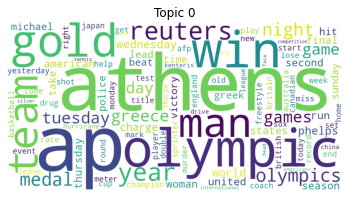

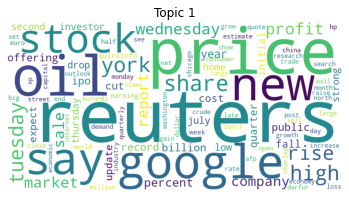

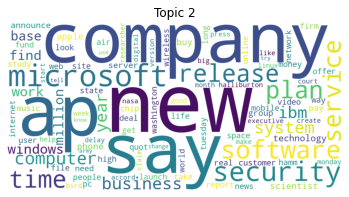

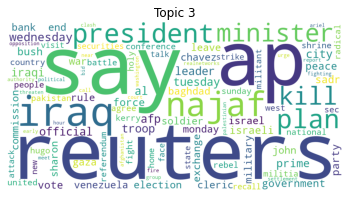

In [38]:
# Generate a word cloud for each topic.
for topic_idx, words in topic_word_weights.items():
    frequencies = dict(zip(words.index, words["weight"]))
    wordcloud = WordCloud(background_color="white", width=1000, height=500).generate_from_frequencies(frequencies)
    # Display image
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.imshow(wordcloud)
    plt.show()

Compare this with the word cloud visualizations in the pre-processing step previously. Does the LDA topic modeling represent the actural four document classes in the training data? What do you think?

For this task, we mainly use a qualitative way to evaluate topic modeling by visually inspecting the word clouds. There are also quantiative ways to evaluate the models, but they are not covered in this course. If you are interested in this, check the following resources:
- [Demonstration of the topic coherence pipeline in Gensim](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/topic_coherence_tutorial.ipynb)
- [Performing Model Selection Using Topic Coherence](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb)
- [Benchmark testing of coherence pipeline on Movies dataset](https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/topic_coherence-movies.ipynb)

<a name="t5"></a>

## Task 5: Supervised Learning - Topic Classification

Topic classification is a task in NLP that involves automatically assigning a given text document to one or more predefined categories or topics. This task is essential for various applications, such as document organization, search engines, sentiment analysis, and more.

In recent years, deep learning models have shown remarkable performance in various NLP tasks, including topic classification. We will explore a neural network-based approach for topic classification using the PyTorch framework. PyTorch provides an efficient way to build and train neural networks with a high degree of flexibility and ease of use.

<a name="t5-1"></a>

### Compute Word Embeddings

We will first look at word embeddings, which represent words as vectors in a high-dimensional space. The key idea behind word embeddings is that words with similar meanings tend to appear in similar contexts, and therefore their vector representations should be close together in this high-dimensional space. Word embeddings have been widely used in various NLP tasks such as sentiment analysis, machine translation, and information retrieval.

There are several techniques to generate word embeddings, but one of the most popular methods is the Word2Vec algorithm, which is based on a neural network architecture. Word2Vec learns embeddings by predicting the probability of a word given its context (continuous bag of words or skip-gram model). The output of the network is a set of word vectors that can be used as embeddings.

We can train a Word2Vec model ourselves, but keep in mind that later on, it's not nice if we don't have embeddings for certain words in the test set. So let's first apply the familiar preprocessing steps to the test set:

In [39]:
# Reformat the test set.
df_test_reformat = reformat_data(df_test)

# NLTK preprocessing.
df_test_with_tokens = answer_tokenize_and_lemmatize(df_test_reformat)

# spaCy preprocessing.
df_test_with_nltk_tokens_and_spacy_tokens = add_spacy_tokens(add_spacy_doc(df_test_with_tokens, nlp))

display(df_test_with_nltk_tokens_and_spacy_tokens)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

,class_idx,class,text,tokens,doc,spacy_tokens
0,3,Business,Fears for T N pension after talks Unions repre...,"[Fears, for, T, N, pension, after, talk, Union...","(Fears, for, T, N, pension, after, talks, Unio...","[fear, t, N, pension, talk, Unions, represent,..."
1,4,Sci/Tech,The Race is On: Second Private Team Sets Launc...,"[The, Race, be, On, :, Second, Private, Team, ...","(The, Race, is, On, :, Second, Private, Team, ...","[race, Second, private, Team, Sets, Launch, Da..."
2,4,Sci/Tech,Ky. Company Wins Grant to Study Peptides (AP) ...,"[Ky., Company, Wins, Grant, to, Study, Peptide...","(Ky., Company, Wins, Grant, to, Study, Peptide...","[Company, win, Grant, Study, Peptides, AP, AP,..."
3,4,Sci/Tech,Prediction Unit Helps Forecast Wildfires (AP) ...,"[Prediction, Unit, Helps, Forecast, Wildfires,...","(Prediction, Unit, Helps, Forecast, Wildfires,...","[prediction, Unit, help, Forecast, Wildfires, ..."
4,4,Sci/Tech,Calif. Aims to Limit Farm-Related Smog (AP) AP...,"[Calif, ., Aims, to, Limit, Farm-Related, Smog...","(Calif., Aims, to, Limit, Farm, -, Related, Sm...","[aim, Limit, Farm, relate, Smog, AP, AP, South..."
...,...,...,...,...,...,...
473,3,Business,New Overtime Rules Take Effect New Bush admini...,"[New, Overtime, Rules, Take, Effect, New, Bush...","(New, Overtime, Rules, Take, Effect, New, Bush...","[New, Overtime, Rules, Effect, New, Bush, admi..."
479,3,Business,"Dollar Holds Gains, Fed Comments Help TOKYO (...","[Dollar, Holds, Gains, ,, Fed, Comments, Help,...","(Dollar, Holds, Gains, ,, Fed, Comments, Help,...","[Dollar, Holds, Gains, Fed, comment, help, TOK..."
481,3,Business,Dark arts of spin evident in phoney war for Ab...,"[Dark, art, of, spin, evident, in, phoney, war...","(Dark, arts, of, spin, evident, in, phoney, wa...","[dark, art, spin, evident, phoney, war, Abbey,..."
482,3,Business,Controversial US Overtime Rules Take Effect Ne...,"[Controversial, US, Overtime, Rules, Take, Eff...","(Controversial, US, Overtime, Rules, Take, Eff...","[controversial, Overtime, Rules, Effect, new, ..."


To obtain the complete model, we combine the `tokens` column into one series and call the `Word2Vec` function.

In [40]:
# Rename the very long variables
df_train_preprocessd = df_with_nltk_tokens_and_spacy_tokens
df_test_preprocessd = df_test_with_nltk_tokens_and_spacy_tokens

# Get all tokens into one series.
tokens_both = pd.concat([df_train_preprocessd["tokens"], df_test_preprocessd["tokens"]])

# Train a Word2Vec model on the NLTK tokens.
w2v_model = Word2Vec(tokens_both.values, vector_size=40, min_count=1)

To obtain the embeddings, we can use the `Word2Vec.wv[word]` syntax. To get multiple vectors nicely next to each other in a 2D matrix, we can call `numpy.vstack`.

In [41]:
print(np.vstack([w2v_model.wv[word] for word in ["rain", "cat", "dog"]]))

[[-2.60392636e-01  3.61957699e-02  1.09209269e-01  1.59883693e-01
   7.47058615e-02 -1.83978200e-01  1.15174890e-01  1.41995341e-01
  -1.27571225e-01  4.41441536e-01 -7.66160041e-02 -4.21129227e-01
  -7.70293251e-02 -1.32060111e-01  4.39062655e-01  2.57349819e-01
  -6.41567782e-02  1.71880454e-01  6.53994977e-02 -2.28234261e-01
  -1.31064489e-01  1.52635470e-03  2.27316573e-01  1.49013713e-01
  -2.45736703e-01  1.41700311e-02 -9.18157026e-02  3.44747216e-01
  -3.31136227e-01 -1.63988218e-01  3.18268031e-01 -1.14187524e-01
  -9.01155993e-02 -3.15312743e-01 -2.72045583e-02  1.96554258e-01
   7.19608963e-01 -4.33225513e-01 -3.80716771e-01 -3.01050067e-01]
 [-5.55762206e-04  1.75153557e-02  1.63081214e-02  4.37505618e-02
   1.91775504e-02 -2.68786456e-02 -9.65814292e-03  4.77873608e-02
   1.68873817e-02  7.72785023e-02 -1.24694523e-03 -4.48038988e-02
  -3.69028486e-02  1.08696317e-04  5.88426664e-02  4.69341688e-02
  -9.38272290e-03  8.82259570e-03  2.31929235e-02 -4.38504890e-02
  -1.6697

The spaCy model we used has a `Tok2Vec` algorithm in its pipeline, so we can directly access the 2D matrix of all word vectors on a document with the `Doc.tensor` attribute. Keep in mind this still contains the embeddings of the stopwords.

In [42]:
print(doc.tensor)

[[ 0.44236845 -0.01180173  0.20908105 ... -0.18478878 -0.17872915
  -0.20212969]
 [ 1.347008   -0.9065002   1.0384194  ...  0.9311755  -0.88710904
  -1.0599288 ]
 [ 0.84580296 -1.3604947   0.8471415  ...  0.95768267 -0.07491717
   0.32537135]
 ...
 [ 1.4835097   0.13096532  0.63991284 ... -1.166823    0.250414
  -0.7703706 ]
 [-0.18388712 -0.7047122   0.49538338 ...  0.26794562 -0.6400709
   0.57972735]
 [-0.44166976 -0.5572643  -0.5958953  ... -0.62469536 -0.9879791
  -0.19887315]]


To prepare the word embeddings for classification, we will add a `tensor` column to both the dataframes for training and testing. Each cell in the `tensor` column should be a tensor array, representing the word embedding vector for the text in the corresponding row. The tensors need to have the same size for both the training and test sets, so we also need to pad the tensors with smaller sizes by adding zeros at the end. We provide a `add_padded_tensors` function in the [utility file](#util) for doing this.

In [43]:
df_train_with_tensor, df_test_with_tensor = add_padded_tensors(df_train_preprocessd, df_test_preprocessd)
display(df_test_with_tensor)

,class_idx,class,text,tokens,doc,spacy_tokens,tensor
0,3,Business,Fears for T N pension after talks Unions repre...,"[Fears, for, T, N, pension, after, talk, Union...","(Fears, for, T, N, pension, after, talks, Unio...","[fear, t, N, pension, talk, Unions, represent,...","[[-0.9206627, 0.7367932, -0.17732513, 1.061838..."
1,4,Sci/Tech,The Race is On: Second Private Team Sets Launc...,"[The, Race, be, On, :, Second, Private, Team, ...","(The, Race, is, On, :, Second, Private, Team, ...","[race, Second, private, Team, Sets, Launch, Da...","[[0.3289305, -0.659908, -0.04628387, 0.459979,..."
2,4,Sci/Tech,Ky. Company Wins Grant to Study Peptides (AP) ...,"[Ky., Company, Wins, Grant, to, Study, Peptide...","(Ky., Company, Wins, Grant, to, Study, Peptide...","[Company, win, Grant, Study, Peptides, AP, AP,...","[[-0.085725844, -1.1698873, 0.5357769, 1.32863..."
3,4,Sci/Tech,Prediction Unit Helps Forecast Wildfires (AP) ...,"[Prediction, Unit, Helps, Forecast, Wildfires,...","(Prediction, Unit, Helps, Forecast, Wildfires,...","[prediction, Unit, help, Forecast, Wildfires, ...","[[-0.092530996, -1.1091797, 0.007843953, 0.410..."
4,4,Sci/Tech,Calif. Aims to Limit Farm-Related Smog (AP) AP...,"[Calif, ., Aims, to, Limit, Farm-Related, Smog...","(Calif., Aims, to, Limit, Farm, -, Related, Sm...","[aim, Limit, Farm, relate, Smog, AP, AP, South...","[[-0.10481978, -0.5771505, 1.3032898, 0.098989..."
...,...,...,...,...,...,...,...
473,3,Business,New Overtime Rules Take Effect New Bush admini...,"[New, Overtime, Rules, Take, Effect, New, Bush...","(New, Overtime, Rules, Take, Effect, New, Bush...","[New, Overtime, Rules, Effect, New, Bush, admi...","[[0.63283896, -0.8598237, 0.18151897, 0.718614..."
479,3,Business,"Dollar Holds Gains, Fed Comments Help TOKYO (...","[Dollar, Holds, Gains, ,, Fed, Comments, Help,...","(Dollar, Holds, Gains, ,, Fed, Comments, Help,...","[Dollar, Holds, Gains, Fed, comment, help, TOK...","[[0.27932516, -1.1461885, 0.29283038, 0.256060..."
481,3,Business,Dark arts of spin evident in phoney war for Ab...,"[Dark, art, of, spin, evident, in, phoney, war...","(Dark, arts, of, spin, evident, in, phoney, wa...","[dark, art, spin, evident, phoney, war, Abbey,...","[[0.6209623, -0.8559445, -0.29310828, 0.090776..."
482,3,Business,Controversial US Overtime Rules Take Effect Ne...,"[Controversial, US, Overtime, Rules, Take, Eff...","(Controversial, US, Overtime, Rules, Take, Eff...","[controversial, Overtime, Rules, Effect, new, ...","[[0.19809127, -0.7492492, 0.23203318, 0.294419..."


<a name="t5-2"></a>

### Build the Classifier 

Our neural network will take the embedding representation of the document as input and predict the corresponding topic using a softmax output layer. We will evaluate the performance of our model using various metrics such as accuracy, precision, recall, and F1-score.

The following code demonstrates how to implement a neural network for topic classification in PyTorch. First let's do some more preparations for our inputs, turning them into PyTorch tensors.

In [44]:
# Transform spaCy tensors into PyTorch tensors.
input_train = torch.from_numpy(np.stack(df_train_with_tensor["tensor"]))
input_test = torch.from_numpy(np.stack(df_test_with_tensor["tensor"]))

# Get the labels, move to 0-indexed instead of 1-indexed.
train_labels = torch.from_numpy(df_train_with_tensor["class_idx"].values) - 1
test_labels = torch.from_numpy(df_test_with_tensor["class_idx"].values) - 1

# One-hot encode labels for training.
train_target = torch.zeros((len(train_labels), 4))
train_target = train_target.scatter_(1, train_labels.unsqueeze(1), 1).unsqueeze(1)

Then, it is time to define our network. The neural net consists of three fully connected layers (`fc1`, `fc2`, and `fc3`) with ReLU activation (`relu`) in between each layer. We flatten the input tensor using `view` before passing it through the fully connected layers. Finally, we apply the softmax activation function (`softmax`) to the output tensor to obtain the predicted probabilities for each class.

In [45]:
class TopicClassifier(nn.Module):
    def __init__(self, input_width, input_length, output_size):
        super(TopicClassifier, self).__init__()
        self.input_width = input_width
        self.input_length = input_length
        self.output_size = output_size

        self.fc1 = nn.Linear(input_width * input_length, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Flatten the input tensor.
        x = x.view(-1, self.input_width * self.input_length)

        # Pass through the fully connected layers with ReLU activation.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        # Apply softmax activation to the output.
        x = self.softmax(x)
        return x

Now it's time to train our network, this may take a while, but the current loss will be printed after every epoch.
If you want to run the code faster, you can also put this notebook on Google Colab and use its provided GPU to speed up computing.

In [46]:
# Define parameters.
n_classes = len(train_labels.unique())
input_size = input_train.shape[1:]
num_epochs = 5
lr = 0.001

# Define model, loss function and optimizer.
model = TopicClassifier(*input_size, output_size=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training loop.
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(zip(input_train, train_target)):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/5], Loss: 1.3852
Epoch [2/5], Loss: 1.3765
Epoch [3/5], Loss: 1.3249
Epoch [4/5], Loss: 1.0777
Epoch [5/5], Loss: 0.8335


<a name="a5"></a>

### Optional Assignment for Task 5

The following code evaluates the model using a confusion matrix.

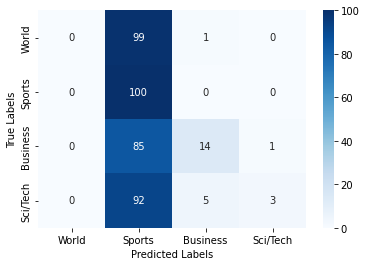

In [47]:
# Evaluate the neural net on the test set.
model.eval()

# Sample from the model.
with torch.no_grad():
    test_outputs = model(input_test)
    # Reuse our previous function to get the label with biggest probability.
    test_pred = np.argmax(test_outputs.detach(), axis=1)

# Set model back to training mode.
model.train()

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Plot the confusion matrix using seaborn
labels = ["World", "Sports", "Business", "Sci/Tech"]
h = sns.heatmap(cm, annot=True, cmap="Blues", fmt="g", xticklabels=labels, yticklabels=labels)
ax = plt.xlabel("Predicted Labels")
ax = plt.ylabel("True Labels")

If you do not feel done with text data yet, there is always more to do. In this optional assignment, you can experiment with the number of epochs, learning rate, vector size, optimizer, neural network architecture, regularization, etc. Also, we only use a small subset of this dataset for performance issues. If you have a high-end computer, you can go to the beginning of this tutorial to increase the size of the subset.

Even during the preprocessing, we could have done some things differently, like making everything lowercase and removing punctuation. Be aware that every choice you make along the way trickles down into your pipeline and can have some effect on your results. Also, take the time to write the code to evaluate the model with more metrics, such as accuracy, precision, recall, and the F1 score.